# Nonlinear Registration

## Introduction

In this exercise, you will implement sum-of-squared differences-based nonlinear registration using the Gauss-Newton algorithm. To simplify the exercise, you will register a 2D (sagittal) slice of a brain MRI scan of two different subjects; the images have been preprocessed (affinely aligned in 3D and resampled) so that you can (*exceptionally, for this exercise!*) assume that world coordinates and voxel coordinates are the same.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries:

In [1]:
import numpy as np
np.set_printoptions( suppress=True )
from matplotlib import pyplot as plt
plt.ion()
from scipy.ndimage import map_coordinates
import nibabel as nib

Read the two 3D scans you'll be working with in this exercise and select 2D slices:

In [2]:
fixed = nib.load( 'IXI092-HH-1436-T1.nii.gz' ).get_fdata()
moving = nib.load( 'IXI097-HH-1619-T1_resampled.nii.gz' ).get_fdata()

fixed, moving = fixed[ ..., 73 ], moving[ ..., 73 ] # get slices

Below are three functions which let you visualize the images and corresponding grids in the same way. You can use these functions through all tasks where needed.

Text(0.5, 0.98, 'Image Grid')

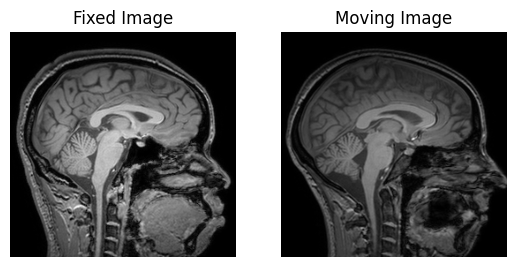

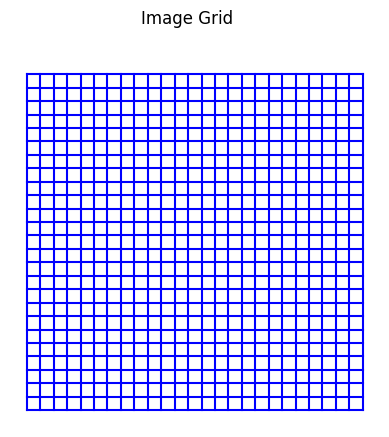

In [3]:
def visualize_image( ax, im, **kwargs ):
    # Visualize an image the same way the grid and vector fields are drawn: to the right means
    # x1 (row number in image matrix) goes up, and to the top means x2 (column number in image 
    # matrix) goes up.
    ax.imshow( np.flipud( im.T ), **kwargs )
    ax.set_aspect( 'equal' )
    ax.axis( False )

def plot_grid( ax, X1, X2, **kwargs ):
    for i in range(X1.shape[0]):
        ax.plot(X1[i,:], X2[i,:], **kwargs)
    for i in range(X1.shape[1]):
        ax.plot(X1[:,i], X2[:,i], **kwargs)

def visualize_grid( ax, X1, X2 ):
    N1, N2 = X1.shape
    plot_grid( ax, X1[ ::10, ::10 ], X2[ ::10, ::10 ], color='b' )
    ax.set_aspect( 'equal' )
    ax.axis( False )

fixed = np.flipud( fixed )
moving = np.flipud( moving )

fig, ax = plt.subplots( 1, 2 )
visualize_image( ax[0], fixed, cmap='gray' )
visualize_image( ax[1], moving, cmap='gray' )
ax[0].set_title("Fixed Image")
ax[1].set_title("Moving Image")

X1, X2 = np.meshgrid( np.arange(fixed.shape[0]), np.arange(fixed.shape[1]), indexing='ij' )
fig, ax = plt.subplots()
visualize_grid( ax, X1, X2 )
fig.suptitle("Image Grid")

In this exercise, you'll be asked to compute and display image histograms, and to indicate the location of a specific intensity value in the histogram plot. The code snippet below shows how this can be done:

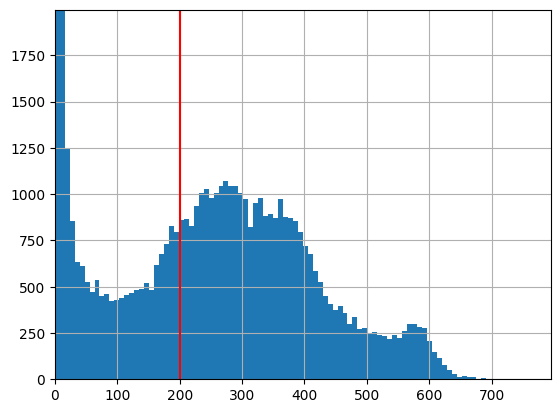

In [4]:
data = fixed
value = np.median( data )

histogram, edges = np.histogram( data.ravel(), bins=100 )
binCenters = ( edges[ 1: ] + edges[ :-1 ] ) / 2
binWidth = edges[ 1 ] - edges[ 0 ]
fig, ax = plt.subplots()
ax.bar( binCenters, histogram, width=binWidth )
ax.set_ylim( 0, histogram[1:].max() )  # clip the entry for background
ax.set_xlim( 0, data.max() )
ax.plot( [ value ]*2, ax.get_ylim(), 'r' )
ax.grid()


## Task 1: Normalize the intensity values of both images

Since MRI images are not calibrated, the pixel intensities in the fixed and the moving image are not necessarily comparable. As a first attempt to normalize the intensity values, divide each image by its maximum intensity value (to bring both images in the range $[0,1]$) and display both images, as well as their histograms, side by side. Are the intensity values now comparable between the two images?
> ***Hints:***
> - To avoid automatic rescaling of the visualization color map, you should perform the visualization as follows:
>        visualize_image( ax, fixed, cmap='gray', vmin=0, vmax=1 )

Compute a *robust* version of the maximum intensity in each image by locating the intensity value in the histogram so that 99% of the image pixels have a lower intensity. For each image, indicate the location of the value you find in the histogram using a verticle line (see code snippet given in the introduction).

Now rescale the image intensities again, this time using the robust maximum value instead. (Intensities higher than the robust maximum should be clipped so that all intensities fall within the range $[0,1]$ after intensity normalization.) Display both normalized images, as well as their histograms, side by side again. Decide which normalization method makes the image intensities more comparable, explain why, and perform the remainder of the exercise using the normalized images of your choice.

795.0
1243.55224609375


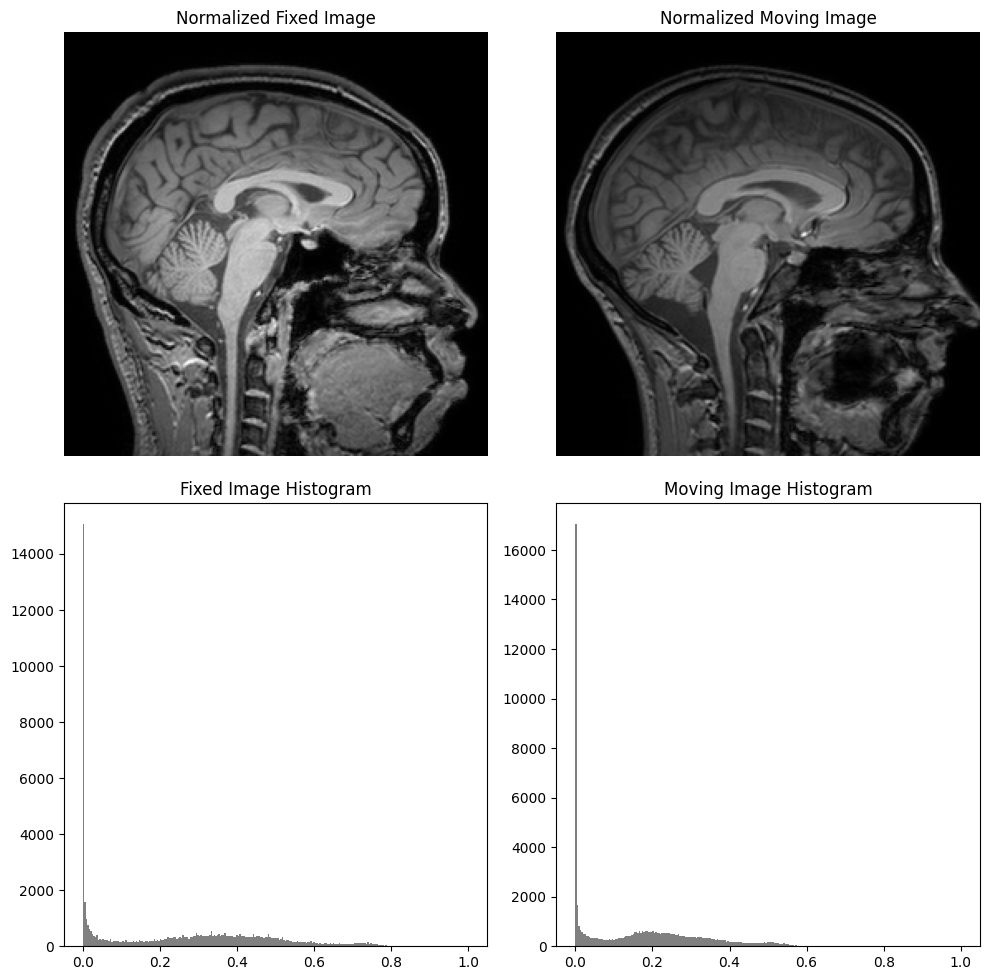

In [5]:
import matplotlib.pyplot as plt

fixed_max = np.max(fixed)
moving_max = np.max(moving)

# Normalization
fixed_normalized = fixed/fixed_max
moving_normalized = moving/moving_max

print(fixed_max)
print(moving_max)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

ax = ax.ravel()

visualize_image(ax[0], fixed_normalized, cmap='gray', vmin=0, vmax=1)
visualize_image(ax[1], moving_normalized, cmap='gray', vmin=0, vmax=1)
ax[0].set_title("Normalized Fixed Image")
ax[1].set_title("Normalized Moving Image")

# Histograms
ax[2].hist(fixed_normalized.ravel(), bins=256, color='gray')
ax[3].hist(moving_normalized.ravel(), bins=256, color='gray')
ax[2].set_title("Fixed Image Histogram")
ax[3].set_title("Moving Image Histogram")

plt.tight_layout()
plt.show()

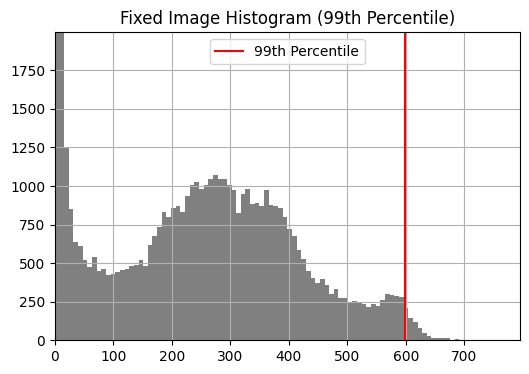

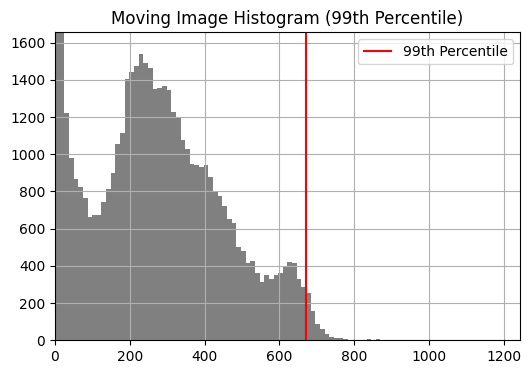

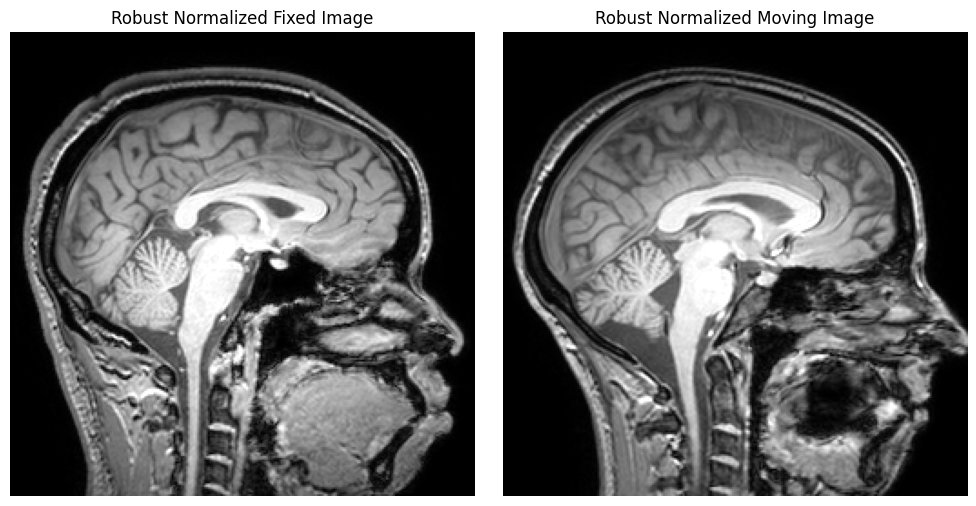

In [6]:
# Compute the 99th percentile for both fixed and moving images
fixed_robust_max = np.percentile(fixed, 99)
moving_robust_max = np.percentile(moving, 99)

# Normalize and clip the images using the robust maximum
fixed_robust_normalized = np.clip(fixed / fixed_robust_max, 0, 1)
moving_robust_normalized = np.clip(moving / moving_robust_max, 0, 1)

# Plot histograms and mark the 99th percentile
def plot_histogram_with_robust_max(data, robust_max, title):
    histogram, edges = np.histogram(data.ravel(), bins=100)
    bin_centers = (edges[1:] + edges[:-1]) / 2
    bin_width = edges[1] - edges[0]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(bin_centers, histogram, width=bin_width, color='gray')
    
    # Set the y-limit to avoid extreme outliers skewing the plot
    ax.set_ylim(0, histogram[1:].max())
    # Set the x-limit to the maximum intensity of the image
    ax.set_xlim(0, data.max())
    
    # Plot a vertical red line for the robust maximum (99th percentile)
    ax.plot([robust_max]*2, ax.get_ylim(), 'r', label="99th Percentile")
    
    ax.set_title(title)
    ax.grid()
    ax.legend()
    plt.show()

# Display images and histograms with robust max marked
plot_histogram_with_robust_max(fixed, fixed_robust_max, title="Fixed Image Histogram (99th Percentile)")
plot_histogram_with_robust_max(moving, moving_robust_max, title="Moving Image Histogram (99th Percentile)")

# Display the robust normalized images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
visualize_image(ax[0], fixed_robust_normalized, cmap='gray')
visualize_image(ax[1], moving_robust_normalized, cmap='gray')
ax[0].set_title("Robust Normalized Fixed Image")
ax[1].set_title("Robust Normalized Moving Image")
plt.tight_layout()
plt.show()


## Task 2: Create basis functions for nonlinear deformation
In order to model the residual deformation in each direction $d=1,\ldots,D$, you are going to use a weighted set of basis functions:
$$
\delta_d(\mathbf{x}, \mathbf{w}_d) = \sum_{m=0}^{M-1} w_{d,m}\phi_m (\mathbf{x})
.
$$
Here $\phi_m (\mathbf{x})$ are $M$ basis functions, and $\mathbf{w}_d$ are the weights for direction $d$. 
For the purpose of this exercise, construct a set of $M=7 \times 7=49$ separable, 2D cubic B-spline basis functions that cover the image area of the fixed image. Include a visualization of the basis functions, plotted in a $7 \times 7$ grid, in your report.

> ***Hint:***
> - You should reuse the code for the 2D B-Spline basis functions that you implemented for the exercise about image smoothing.

For the purpose of the exercise, retain only the central part of $5 \times 5$ basis functions, removing all the B-splines that are centered on one of the image edges. This will avoid strangle-looking, large deformations of the image edges later on.

> ***Hint:***
> - There are several ways of doing this. One option is to construct the 25 2D basis functions from only the 5 central 1D basis functions in each direction to start with:  
>        np.kron( Phi2[:,1:-1], Phi1[:,1:-1] ) 
> instead of 
>        np.kron( Phi2, Phi1 )


In [7]:
# cubic B-spline interpolation
def eval_cubic_BSpline(x):
    """
    Evaluates the uniform B-spline of cubic order "3" at the locations in vector "x"
    """

    x = np.asarray(x)  # Ensure x is a NumPy array
    y = np.zeros_like(x)

    # evaluate the uniform ubic B-spline at the locations in x
    abs_x = np.abs(x)
    
    # Different cases for cubic B-spline
    y[abs_x < 1] = (4 - 6 * abs_x[abs_x < 1]**2 + 3 * abs_x[abs_x < 1]**3) / 6.0
    y[(abs_x >= 1) & (abs_x < 2)] = (2 - abs_x[(abs_x >= 1) & (abs_x < 2)])**3 / 6.0
    y[abs_x >= 2] = 0

    return y

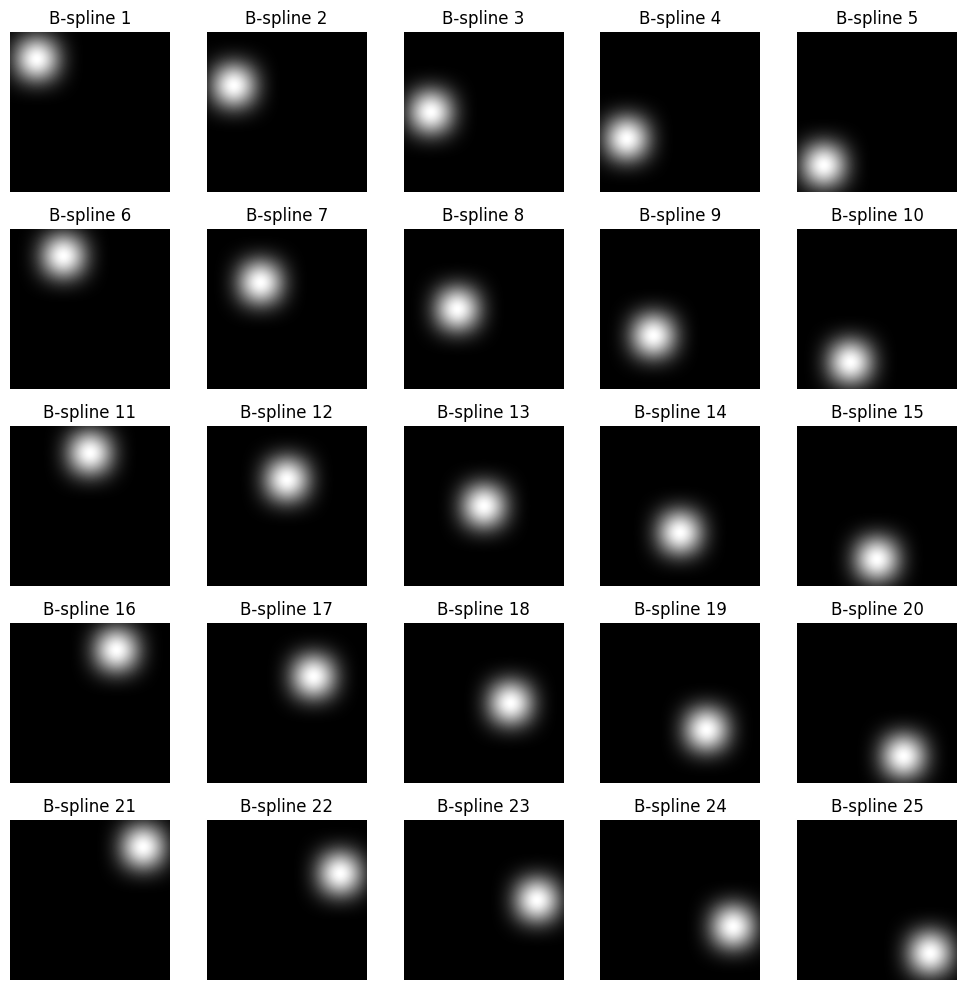

In [8]:
# Grid and spline setup
N_dim = 256  # Image dimension
M_dim = 7    # Number of basis functions in each direction

# Knot spacing for the B-splines
h1 = (N_dim - 1) / (M_dim - 1)

# Create the B-spline basis functions for each dimension
phi1 = np.zeros((N_dim, M_dim))
phi2 = np.zeros((N_dim, M_dim))

x = np.arange(N_dim)
for i in range(M_dim):
    centered = i * h1
    shifted = (x - centered) / h1
    phi1[:, i] = eval_cubic_BSpline(shifted)
    phi2[:, i] = eval_cubic_BSpline(shifted)

# Form the 2D B-spline basis functions using the Kronecker product
Phi = np.kron(phi2, phi1)  # Full 7x7 grid of basis functions

# Now retain only the central 5x5 basis functions
Phi_central = np.kron(phi2[:, 1:-1], phi1[:, 1:-1])  # 5x5 grid of basis functions

# Visualize the central 25 basis functions in a 5x5 grid
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i in range(25):
    ax = axs[i // 5, i % 5]
    basis_fn = Phi_central[:, i].reshape(N_dim, N_dim, order='F')
    
    ax.imshow(basis_fn, cmap='gray')
    ax.set_title(f'B-spline {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

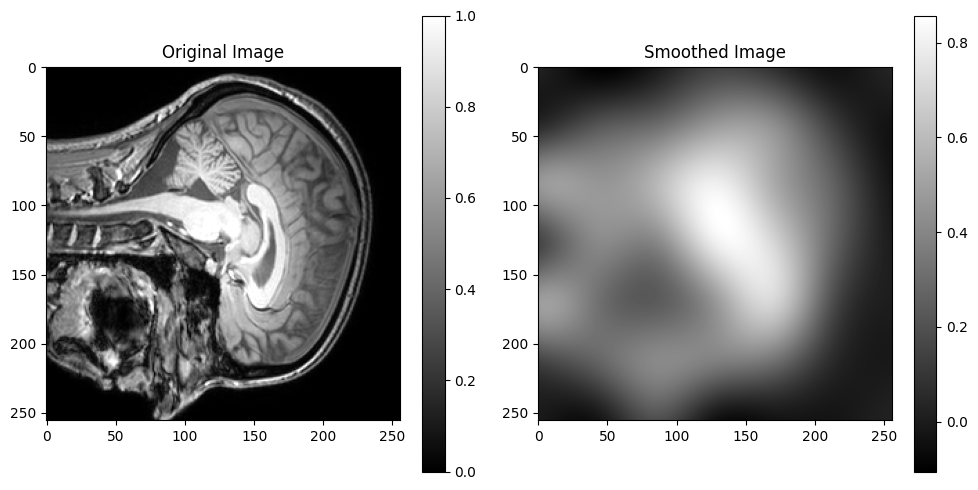

In [28]:
# Vectorize the 2D image into a 1D signal using column-major order ('F')
m = moving_robust_normalized.reshape(-1, 1, order='F')

# Compute the smoothing weights
Phi_inv = np.linalg.inv(Phi.T @ Phi)
Phi_inv_Phi_T = Phi_inv @ Phi.T 
w = Phi_inv_Phi_T @ m  # Smoothing weights

# Expand the weights to get the smoothed signal
hat_t = Phi @ w  # Smoothed 1D signal

# Re-arrange the smoothed 1D signal back into a 2D image
hat_T = hat_t.reshape(N_dim, N_dim, order='F')

# Show the original and smoothed images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(moving_robust_normalized, cmap='gray')
plt.title('Original Image')
plt.colorbar()

# Smoothed image
plt.subplot(1, 2, 2)
plt.imshow(hat_T, cmap='gray')
plt.title('Smoothed Image')
plt.colorbar()

plt.tight_layout()
plt.show()

## Task 3: Manipulate the image locally with basis function

In this task, you will use two weight vectors $\mathbf{w}_1$ and $\mathbf{w}_2$ to control the transformation model 
$$ 
y_d(\mathbf{x}, \mathbf{w}_d) = x_d + \delta_d(\mathbf{x}, \mathbf{w}_d), \quad d=1,2
,
$$
and visualize the effect of changing these weights on the resulting image deformation.
For each choice of weights, you should show (1) how a regular image grid defined in the space of the fixed image looks after deformation, and (2) the corresponding interpolated moving image, resampled to the image grid of the fixed image.

In a first experiment, set all elements of $\mathbf{w}_2$ to zero, and set all elements *except one* in $\mathbf{w}_1$ to zero. Try a few different values for the one non-zero entry, show each time the resulting deformated image grid and the interpolated moving image, and comment on what you see. 

In a second experiment, apply a non-zero value to the corresponding (i.e., controlling the same 2D basis function) element in $\mathbf{w}_2$ as well. Again visualize the result and comment.

> ***Hints:***
> - Plot the deformed grid with the function visualize_grid() provided in the introduction, following the example of the non-deformed grid that was given. 
> - View your deformed moving image with the function visualize_image() that was provided.

In [14]:
def delta_d(w_d, Phi):
    """
    Compute the deformation delta_d for each direction d.
    Arguments:
    - w_d: weights vector for direction d
    - Phi: 2D basis functions
    
    Returns:
    - The deformation for each point in the grid
    """
    return np.dot(Phi, w_d)

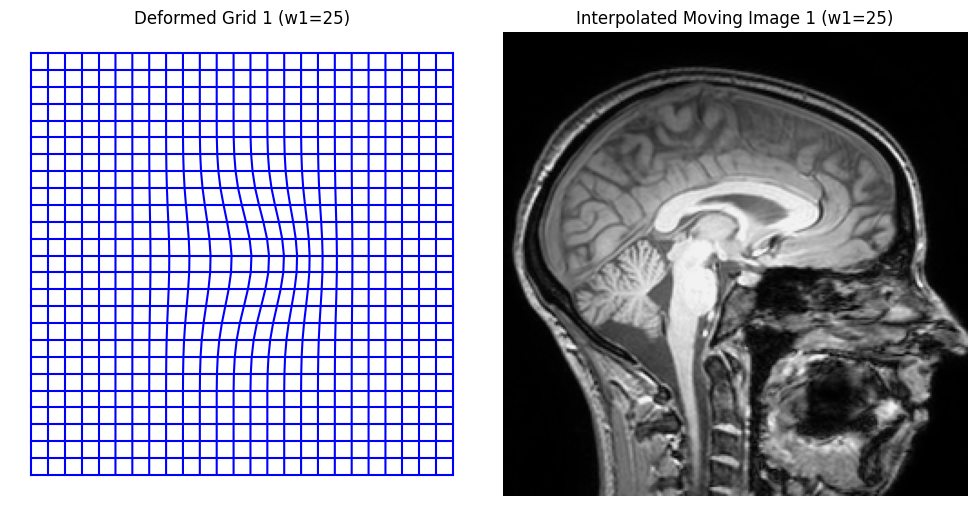

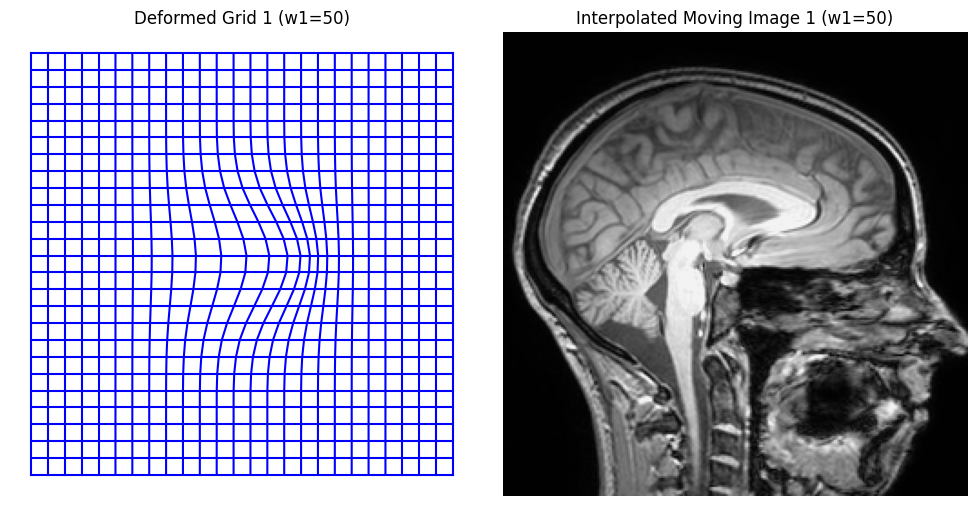

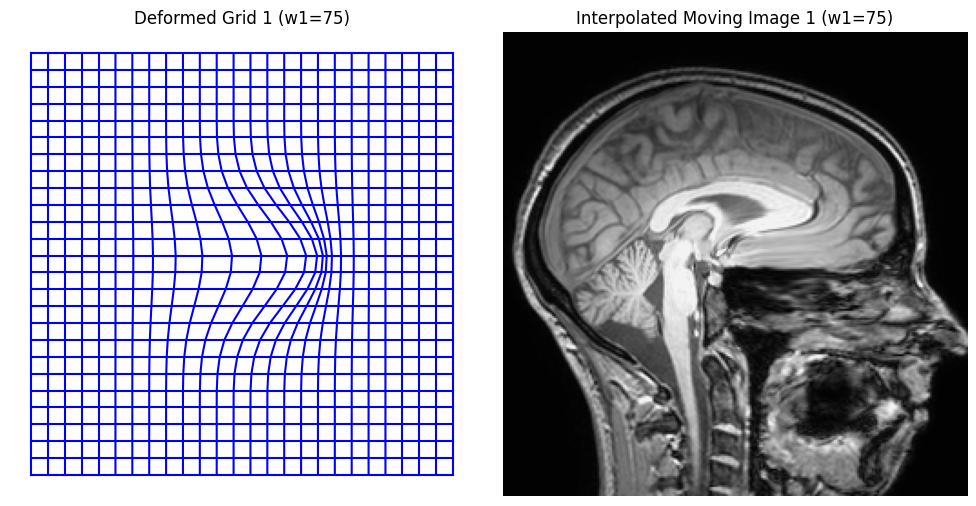

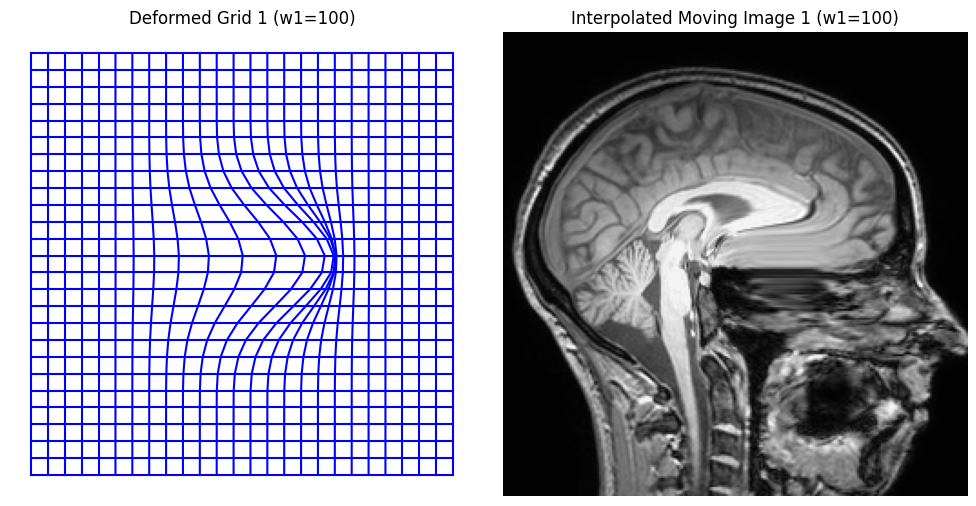

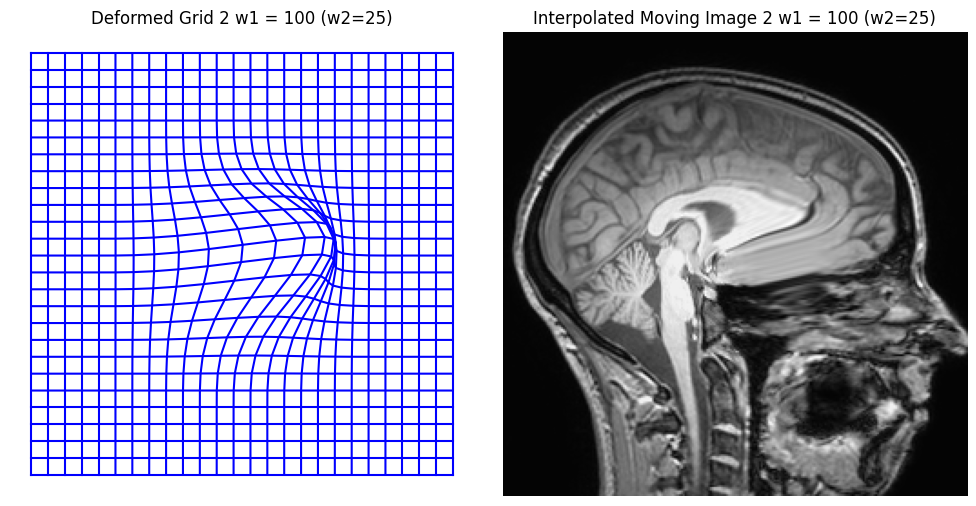

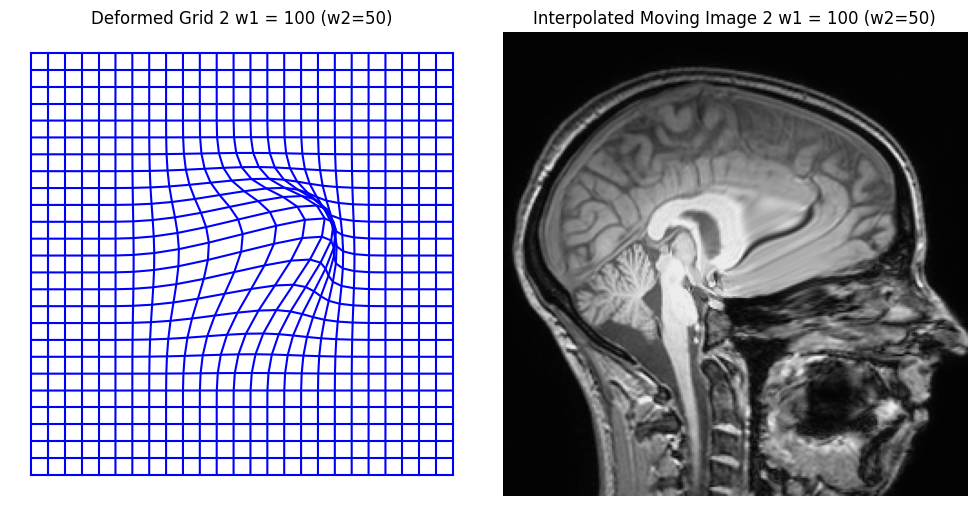

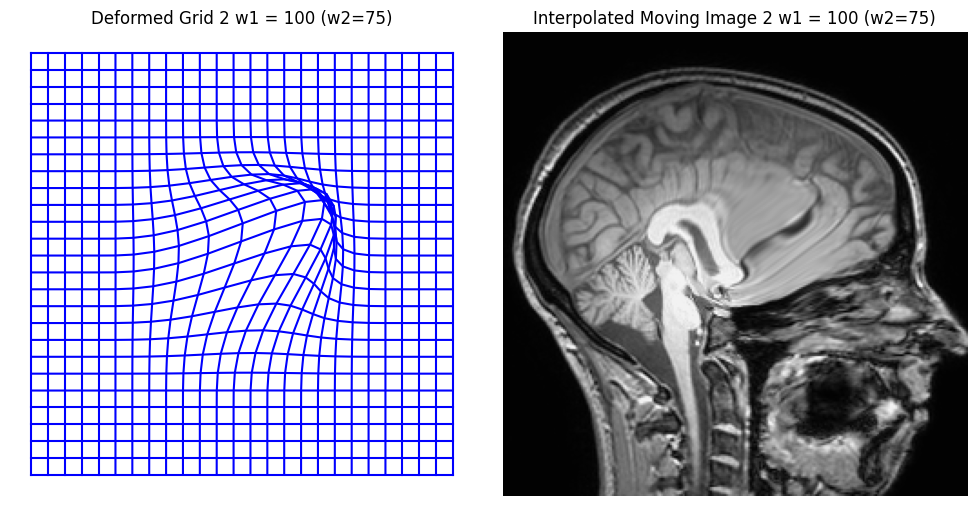

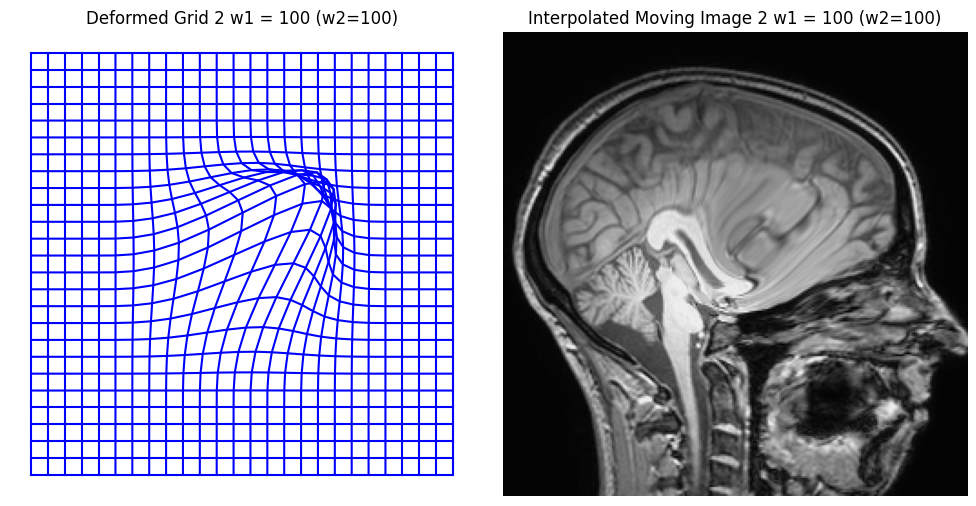

In [31]:
# Define the image grid and basis functions (assuming Phi_central from Task 2)
N_dim = 256  # Image dimension
n_bsplines = 25   # Number of central basis functions

# Create a meshgrid for the image grid
# X1, X2 = np.meshgrid(np.arange(N_dim), np.arange(N_dim), indexing='ij')
X1, X2 = np.meshgrid( np.arange(fixed.shape[0]), np.arange(fixed.shape[1]), indexing='ij' )


# Vectorize the grid for easier manipulation
grid_x = np.vstack([X1.ravel(), X2.ravel()]).T

# Experiment 1: Set w2 to zero and use a single non-zero value in w1
w1 = np.zeros(n_bsplines)
w2 = np.zeros(n_bsplines)

# Select one basis function to control the deformation
index = 12  # You can experiment with different indices
w1[index] = 50.0  # Modify this value for different deformation magnitudes

values = [25, 50, 75, 100]

# Compute the deformation for the different values of w1
for v in values:
    w1[index] = v
    delta_x1 = delta_d(w1, Phi_central)
    delta_x2 = delta_d(w2, Phi_central)
    
    # Apply the deformation to the grid
    deformed_grid_x1 = grid_x[:, 0] + delta_x1
    deformed_grid_x2 = grid_x[:, 1] + delta_x2
    
    # Reshape the deformed grid for visualization
    deformed_X1 = deformed_grid_x1.reshape(N_dim, N_dim)
    deformed_X2 = deformed_grid_x2.reshape(N_dim, N_dim)

    # Interpolate the moving image using the deformed grid
    def_interpolated_moving_img = map_coordinates(moving_robust_normalized, (deformed_grid_x1, deformed_grid_x2), order=3, mode='nearest')
    def_interpolated_moving_img = def_interpolated_moving_img.reshape(N_dim, N_dim)
    
    # Visualize the deformed grid
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    visualize_grid(ax[0], deformed_X1, deformed_X2)
    ax[0].set_title(f"Deformed Grid 1 (w1={v})")
    
    # Visualize the interpolated moving image
    visualize_image(ax[1], def_interpolated_moving_img, cmap='gray')
    ax[1].set_title(f"Interpolated Moving Image 1 (w1={v})")
    
    plt.tight_layout()
    plt.show()

# Experiment 2: Apply a non-zero value to the corresponding element in w2
w2[index] = 50.0  # Control the same basis function in both directions

# Compute the deformation for the different values of w2
for v in values:
    w2[index] = v
    delta_x1 = delta_d(w1, Phi_central)
    delta_x2 = delta_d(w2, Phi_central)

    # Apply the deformation to the grid
    deformed_grid_x1 = grid_x[:, 0] + delta_x1
    deformed_grid_x2 = grid_x[:, 1] + delta_x2

    # Reshape the deformed grid for visualization
    deformed_X1 = deformed_grid_x1.reshape(N_dim, N_dim)
    deformed_X2 = deformed_grid_x2.reshape(N_dim, N_dim)

    # Interpolate the moving image using the deformed grid
    def_interpolated_moving_img = map_coordinates(moving_robust_normalized, (deformed_grid_x1, deformed_grid_x2), order=3, mode='nearest')
    def_interpolated_moving_img = def_interpolated_moving_img.reshape(N_dim, N_dim)

    # Visualize the deformed grid and moving image for Experiment 2
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Visualize the deformed grid
    visualize_grid(ax[0], deformed_X1, deformed_X2)
    ax[0].set_title(f"Deformed Grid 2 w1 = 100 (w2={v})")

    # Visualize the interpolated moving image
    visualize_image(ax[1], def_interpolated_moving_img, cmap='gray')
    ax[1].set_title(f"Interpolated Moving Image 2 w1 = 100 (w2={v})")

    plt.tight_layout()
    plt.show()

## Task 4: Implement Gauss-Newton optimization
Search for the weight vector $\mathbf{w} = (\mathbf{w}_1, \mathbf{w}_2)^T$ that minimizes the sum-of-squared-differences energy
$$
E(\mathbf{w}) = \sum_{n=1}^N \left[ \mathcal{F}(\mathbf{x}_n) - \mathcal{M}(\mathbf{y}(\mathbf{x}_n, \mathbf{w})) \right]^2
,
$$
using the Gauss-Newton algorithm described on page 24-25 in the book.
Start from a zero weight vector $\mathbf{w}$ (corresponding to no deformation), and update $\mathbf{w}$ for 100 iterations. For the first and every 20-th subsequent iteration, show both the deformed image grid and the resampled moving image. Also plot how the energy changes across all the 100 iterations.

> ***Hints:***
> - Use a $\mathbf{\delta}$ step value of e.g. $0.001$
> - The diagonal elements of the matrix $\mathbf{G}_1$ contain partial spatial derivatives of the moving image in the first dimension (row direction). If y1 and y2 are vectors containing the mapped coordinates (first and second dimension, respectively) of all $N$ pixels of the fixed image, these diagonal elements can be approximated using 
>        
>   ( map_coordinates( moving, [ y1 + delta, y2 ] ) - map_coordinates( moving, [ y1, y2 ] ) ) / delta
>
>     for a small value of delta. The same applies to $\mathbf{G}_2$ (where delta is added to y2 instead of y1).
> - For an efficient implementation, it is worth considering what the effect is of $\mathbf{G}_d \boldsymbol{\Phi}$ on $\boldsymbol{\Phi}$ *without* implementing it literally as a matrix product.
> - If you find that the energy does not consistently go down across the iterations (by visual inspection of the energy curve), you can try to implement the Levenberg-Marquardt variant described in the book.


## Task 5: Experiment with different numbers of Basis Functions

Re-run the registration when the number of basis functions is altered (e.g., $3x3$ or $7x7$ instead of $5x5$) and inspect the outcomes. In your report, comment on differences in the results.